In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from pathlib import Path
import shutil
import os

import spikeinterface.full as si  # import core only
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
from spikeinterface.sortingcomponents.motion import correct_motion_on_peaks

from kilosort import io

#import spikeinterface.extractors as se
#import spikeinterface.preprocessing as spre
#import spikeinterface.sorters as ss
#import spikeinterface.postprocessing as spost
#import spikeinterface.qualitymetrics as sqm
#import spikeinterface.comparison as sc
#import spikeinterface.exporters as sexp
#import spikeinterface.curation as scur
#import spikeinterface.widgets as sw

#from spikeinterface.preprocessing import get_motion_parameters_preset, get_motion_presets
from spikeinterface.sortingcomponents.motion import estimate_motion, interpolate_motion

In [2]:
############### INPUTS ###############
IN1 = 'kendra_scrappy_0124a_g0'
IN2 = 0

spikeglx_folder = f"/ix1/pmayo/lab_NHPdata/{IN1}/"
preprocess_folder = spikeglx_folder+"figs/preprocess"
motion_folder = spikeglx_folder+f"/{IN1}_imec{IN2}/motion"

os.makedirs(preprocess_folder, exist_ok=True)

#spikeglx_folder = '/ix1/pmayo/lab_NHPdata/kendra_scrappy_0130a_g0'
#dredge_type = 'lfp' # ap

stream_names, stream_ids = si.get_neo_streams('spikeglx', spikeglx_folder)
stream_names

['imec1.ap', 'imec0.ap', 'nidq']

# Read in data

* Neuropixels -- [read_spikeglx](https://spikeinterface.readthedocs.io/en/stable/api.html#spikeinterface.extractors.read_spikeglx)
* Plexon (after converting to binary) -- [read_binary](https://spikeinterface.readthedocs.io/en/stable/api.html#spikeinterface.core.read_binary)

In [3]:
# Read in raw recording 
RAW_REC = si.read_spikeglx(spikeglx_folder, stream_name=f'imec{IN2}.ap', load_sync_channel=False)
RAW_REC

SpikeGLXRecordingExtractor: 384 channels - 29999.994118 Hz - 1 segments - 188,156,151 samples 
                            6,271.87s (1.74 hours) - int16 dtype - 134.58 GiB

(384,)


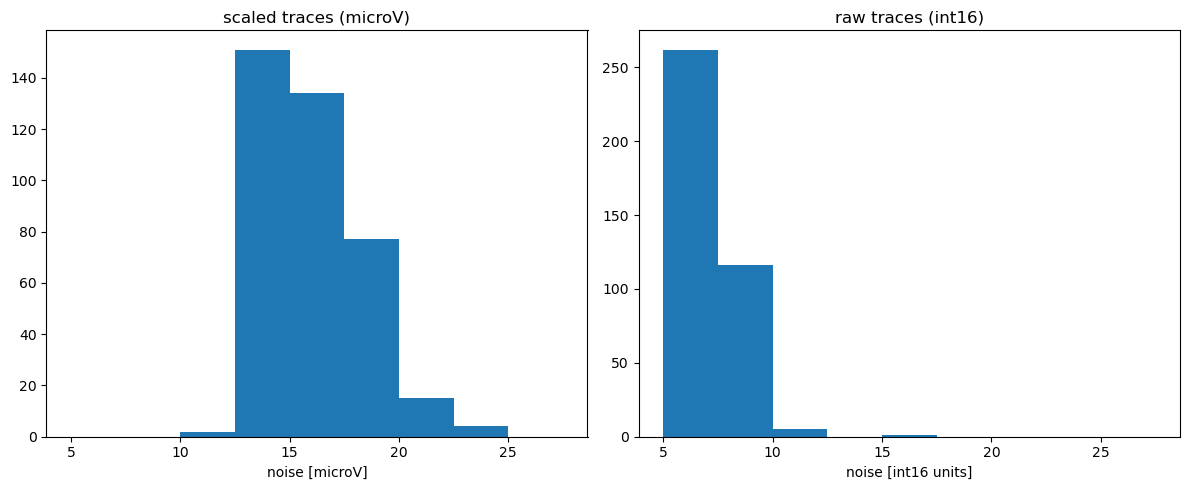

In [47]:
# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(RAW_REC, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(RAW_REC, return_scaled=False)

print(noise_levels_int16.shape)

# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot scaled traces (microV)
axes[0].hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
axes[0].set_title('scaled traces (microV)')
axes[0].set_xlabel('noise [microV]')

# Plot raw traces (int16)
axes[1].hist(noise_levels_int16, bins=np.arange(5, 30, 2.5))
axes[1].set_title('raw traces (int16)')
axes[1].set_xlabel('noise [int16 units]')

output_path = os.path.join(preprocess_folder, 'noise_dists.png')
plt.tight_layout()
plt.savefig(output_path)

# Preprocessing recording
1. Highpass filter
2. Tossing bad channels
3. Common reference

In [4]:
def preprocess_recording(raw_rec, save_path=None):
    raw_rec = raw_rec.astype('float32')
    
    rec1 = si.highpass_filter(raw_rec, freq_min=400.)
    bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
    rec2 = rec1.remove_channels(bad_channel_ids)
    print('bad_channel_ids', bad_channel_ids)
    
    rec3 = si.phase_shift(rec2)
    rec4 = si.common_reference(rec3, operator="median", reference="global")
    rec = rec4

    if save_path is not None:
        # here we use static plot using matplotlib backend
        fig, axs = plt.subplots(ncols=3, figsize=(20, 10))
        
        si.plot_traces(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
        si.plot_traces(rec3, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
        si.plot_traces(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
        for i, label in enumerate(('hp filter', 'phase shift', 'cmr')):
            axs[i].set_title(label)
    
        
            output_path = os.path.join(save_path, 'preprocess_steps.png')
            plt.tight_layout()
            plt.savefig(output_path)
    
        # plot some channels
        fig, ax = plt.subplots(figsize=(20, 10))
        some_chans = rec.channel_ids[[100, 150, 200, ]]
        si.plot_traces({'filter':rec1, 'cmr': rec4}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)

        output_path = os.path.join(save_path, 'preprocess_chans.png')
        plt.tight_layout()
        plt.savefig(output_path)
    
    return rec, bad_channel_ids

In [19]:
REC, bad_channel_ids = preprocess_recording(RAW_REC, save_path=None) #preprocess_folder)

bad_channel_ids ['imec0.ap#AP191']


In [21]:
from probeinterface import ProbeGroup, write_prb

probe_path = DATA_DIRECTORY / 'probe.prb'

probe = REC.get_probe()  # From SpikeInterface tutorial, or recording.get_probe()
pg = ProbeGroup()
pg.add_probe(probe)

# CHANGE THIS PATH to wherever you want to save your probe file.
write_prb(probe_path, pg)

print(probe)

Probe - 383ch - 1shanks


In [48]:
noise_levels_int16 = si.get_noise_levels(REC, return_scaled=False)

job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(REC,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)

peak_locations = localize_peaks(REC, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect peaks using locally_exclusive (workers: 40 processes):   0%|          | 0/6273 [00:00<?, ?it/s]

localize peaks using center_of_mass (workers: 40 processes):   0%|          | 0/6273 [00:00<?, ?it/s]

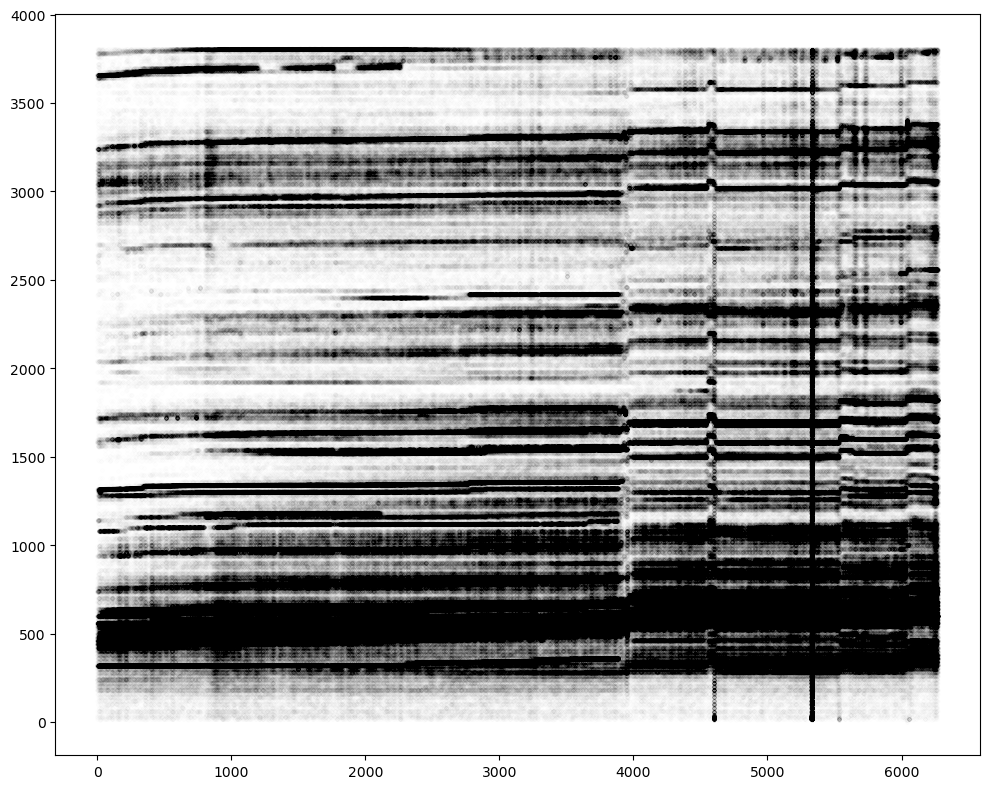

In [50]:
# check for drifts
fs = REC.sampling_frequency
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

output_path = os.path.join(preprocess_folder, 'peak_times_depths1.png')
plt.tight_layout()
plt.savefig(output_path)

# Motion/Drift Detection
1. Bandpass filter
2. Common reference
3. Correct motion w/ dredge

In [24]:
def preprocess_for_drift_correction(raw_rec, bad_channel_ids):
    rec1 = raw_rec.astype('float32')
    
    rec2 = si.bandpass_filter(rec1, freq_min=300.0, freq_max=5000.0)
    rec3 = si.common_reference(rec2, reference="global", operator="median")

    rec4 = rec3.remove_channels(bad_channel_ids)
    print('bad_channel_ids', bad_channel_ids)
    
    return rec4

In [25]:
FILT_REC1 = preprocess_for_drift_correction(RAW_REC, bad_channel_ids)

## High-level API --> for actually doing drift correction

In [26]:
DRIFT_REC = si.correct_motion(recording=FILT_REC1, preset="dredge", folder=motion_folder)

noise_level (workers: 4 processes):   0%|          | 0/20 [00:00<?, ?it/s]

detect and localize (workers: 4 processes):   0%|          | 0/6273 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

In [27]:
motion_info = si.load_motion_info(motion_folder)
motion = motion_info["motion"]

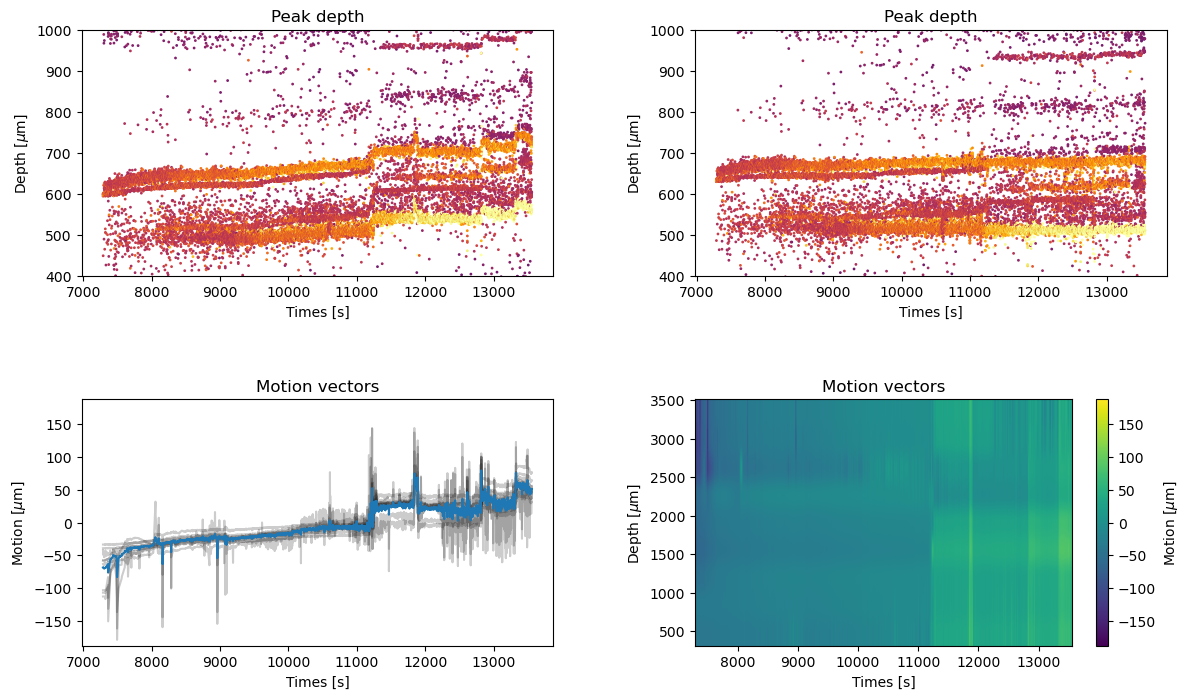

In [34]:
fig = plt.figure(figsize=(14, 8))

si.plot_motion_info(motion_info, FILT_REC1, figure=fig, depth_lim=(400, 1000), color_amplitude=True, amplitude_cmap="inferno", scatter_decimate=10,)

output_path = os.path.join(preprocess_folder, 'motion_info.png')
plt.savefig(output_path)

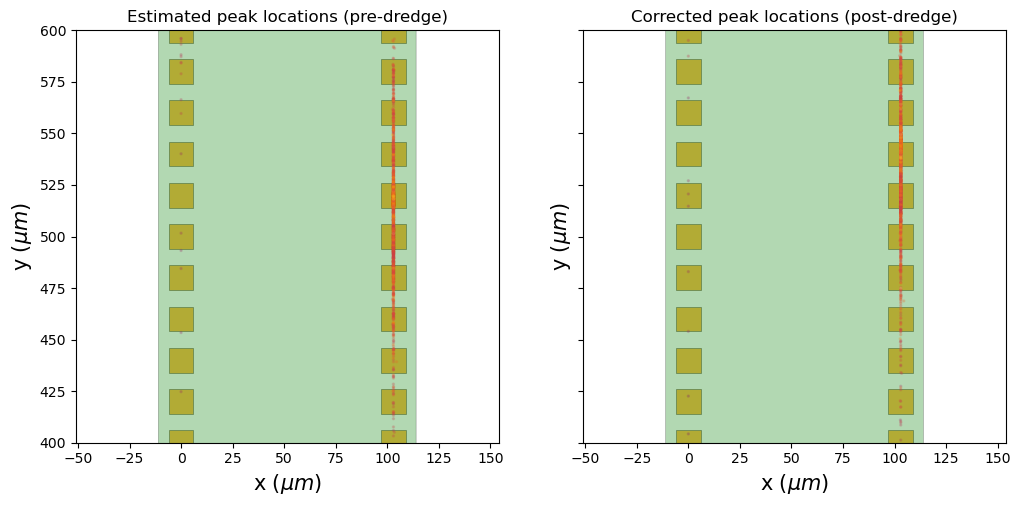

In [43]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 8), sharey=True)

ax = axs[0]
si.plot_probe_map(FILT_REC1, ax=ax)

peaks = motion_info["peaks"]
sr = FILT_REC1.get_sampling_frequency()
time_lim0 = 750.0
time_lim1 = 1500.0
mask = (peaks["sample_index"] > int(sr * time_lim0)) & (peaks["sample_index"] < int(sr * time_lim1))
sl = slice(None, None, 5)
amps = np.abs(peaks["amplitude"][mask][sl])
amps /= np.quantile(amps, 0.95)
c = plt.get_cmap("inferno")(amps)
axs[0].set_title('Estimated peak locations (pre-dredge)')

color_kargs = dict(alpha=0.2, s=2, c=c)

peak_locations = motion_info["peak_locations"]
# color='black',
ax.scatter(peak_locations["x"][mask][sl], peak_locations["y"][mask][sl], **color_kargs)

peak_locations2 = correct_motion_on_peaks(peaks, peak_locations, motion, FILT_REC1)

ax = axs[1]
si.plot_probe_map(FILT_REC1, ax=ax)
#  color='black',
ax.scatter(peak_locations2["x"][mask][sl], peak_locations2["y"][mask][sl], **color_kargs)
axs[1].set_title('Corrected peak locations (post-dredge)')

ax.set_ylim(400, 600)

output_path = os.path.join(preprocess_folder, 'spatial_spread.png')
plt.savefig(output_path)

# Apply Drift Correction

In [13]:
#from spikeinterface.sortingcomponents.motion import interpolate_motion

motion_info = si.load_motion_info(motion_folder)
motion = motion_info["motion"]

REC_CORRECTED = interpolate_motion(recording=REC, motion=motion_info['motion'], **motion_info['parameters']['interpolate_motion_kwargs'])

In [7]:
job_kwargs = dict(n_jobs=40, chunk_duration='1s', progress_bar=True)

DATA_DIRECTORY = Path(spikeglx_folder+f"/{IN1}_imec{IN2}/corrected")

REC_CORRECTED = REC_CORRECTED.save(folder=DATA_DIRECTORY, format='binary', **job_kwargs)

write_binary_recording 
engine=process - n_jobs=40 - samples_per_chunk=29,999 - chunk_memory=43.83 MiB - total_memory=1.71 GiB - chunk_duration=1.00s (999.97 ms)


write_binary_recording (workers: 40 processes):   0%|          | 0/6273 [00:00<?, ?it/s]

In [ ]:
from kilosort import io

DATA_DIRECTORY = Path(spikeglx_folder+f"/{IN1}_imec{IN2}/corrected")
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)

dtype = np.int16
filename, N, c, s, fs, probe_path = io.spikeinterface_to_binary(
    REC_CORRECTED, DATA_DIRECTORY, data_name='kendra_scrappy_0130a_g0_t0.imec0_DREDGE.ap.bin', dtype=dtype,
    chunksize=60000, export_probe=True, probe_name='probe.prb')

# Test run Kilosort

In [14]:
from probeinterface import write_prb

probe_path = DATA_DIRECTORY / 'probe.prb'

pg = REC_CORRECTED.get_probegroup()
write_prb(probe_path, pg)

:
from probeinterface import ProbeGroup, write_prb

probe = ...  # From SpikeInterface tutorial, or recording.get_probe()

# Multiple probes can be added to a ProbeGroup. We only have one, but a
# ProbeGroup wrapper is still necessary for `write_prb` to work.
pg = ProbeGroup()
pg.add_probe(probe)
# CHANGE THIS PATH to wherever you want to save your probe file.
write_prb('.../test_prb.prb', pg)

In [ ]:
from kilosort import run_kilosort, DEFAULT_SETTINGS

# NOTE: 'n_chan_bin' is a required setting, and should reflect the total number
#       of channels in the binary file, while probe['n_chans'] should reflect
#       the number of channels that contain ephys data. In many cases these will
#       be the same, but not always. For example, neuropixels data often contains
#       385 channels, where 384 channels are for ephys traces and 1 channel is
#       for some other variable. In that case, you would specify
#       'n_chan_bin': 385.

# Specify probe configuration.
probe = io.load_probe(probe_path)
print(probe)

settings = DEFAULT_SETTINGS
settings['probe'] = probe
settings['n_chan_bin'] = probe['n_chan']+2
settings['fs'] = 30000
settings['data_dir'] = DATA_DIRECTORY.parent
#print(settings)

# This command will both run the spike-sorting analysis and save the results to
# `DATA_DIRECTORY`.
ops, st, clu, tF, Wall, similar_templates, is_ref, \
    est_contam_rate, kept_spikes = run_kilosort(
        settings=settings, probe=probe, data_dtype='int16', save_preprocessed_copy=False
        )

kilosort.run_kilosort: Kilosort version 0.1.dev1164+gdfaaf6b.d20240502
kilosort.run_kilosort: Python version 3.10.14
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Linux-3.10.0-1160.71.1.el7.x86_64-x86_64-with-glibc2.17 x86_64
kilosort.run_kilosort: x86_64
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA A100-PCIE-40GB 39.38GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting /ix1/pmayo/lab_NHPdata/kendra_scrappy_0124a_g0/kendra_scrappy_0124a_g0_imec0/kendra_scrappy_0124a_g0_t0.imec0.ap.bin
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 188156151
kilosort.run_kilosort: N seconds: 6271.8717
kilosort.run_kilosort: N batches: 3136


{'chanMap': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 

kilosort.run_kilosort: Preprocessing filters computed in  124.11s; total  124.12s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    10.20 %
kilosort.run_kilosort: Memory:        3.69 %     |     18.58   /   503.65 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:    5.46 %     |      2.15   /    39.38 GB
kilosort.run_kilosort: Allocated:     0.02 %     |      0.01   /    39.38 GB
kilosort.run_kilosort: Max alloc:     3.31 %     |      1.30   /    39.38 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.spikedetect: Re-compu